In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [5, 10, 25, 50, 100, 200, ] 
roc_periods = [5, 10]
multiplier = 20
bankroll = 15000
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_CL_cont_non_active_included.pickle')
contract = contract.loc['20180101': '20181231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
vols = pd.DataFrame({'close': contract.close,})
vols['returns'] = vols['close'].pct_change()
vols['vol_returns'] = vols['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols['vol_price'] = vols['vol_returns'] * vols['close']
vols['vol_price_alt'] = vols['close'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()

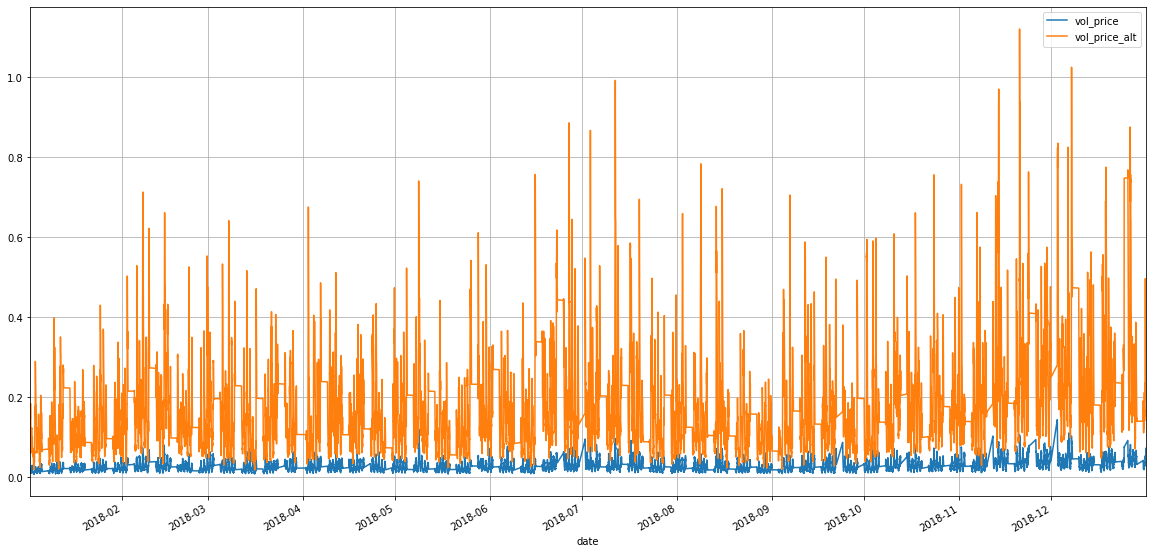

In [5]:
vols[['vol_price', 'vol_price_alt']].plot(figsize=(20,10), grid=True);

In [6]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

11489.210822807865

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-01-02 02:37:00,60.20,60.48,60.13,60.47,4573,10881,0.350000
1,2018-01-02 03:25:00,60.48,60.73,60.47,60.68,4896,13259,0.304437
2,2018-01-02 06:48:00,60.68,60.73,60.55,60.62,4668,11861,0.261917
3,2018-01-02 08:54:00,60.63,60.74,60.60,60.65,4537,11536,0.230285
4,2018-01-02 09:31:00,60.64,60.65,60.48,60.53,4092,11354,0.217618
...,...,...,...,...,...,...,...,...
11087,2018-12-31 20:19:00,45.55,45.57,45.24,45.52,5740,12599,0.333466
11088,2018-12-31 20:25:00,45.52,45.53,44.91,44.95,5638,13157,0.340541
11089,2018-12-31 20:28:00,44.95,45.58,44.89,45.47,4634,11601,0.349170


In [8]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [9]:
def carver(data, periods, smooth, *args):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'carver_{periods}']

In [10]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    return data[f'ema_{periods}']

In [11]:
def breakout(data, periods, smooth, *args):
    data['max'] = (data.close >= data.close.rolling(periods).max()) * 1
    data['min'] = (data.close <= data.close.rolling(periods).min()) * 1
    data[f'breakout_{periods}'] = (data['max'] - data['min']).ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [12]:
def diff(data, periods, smooth, vol):
    data = data.copy()
    data['diff'] = data.close.pct_change(periods) * 100
    data['diff_norm'] = data['diff'] / vol
    data[f'diff_{periods}'] = data['diff_norm'].ewm(span=smooth).mean()
    return data[f'diff_{periods}']

In [13]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [14]:
vols = vol(data, vol_lookback)

In [15]:
def combine(data, multi_periods, smooth, vol, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p, smooth, vol) for p in multi_periods]).T.mean(axis=1)
    return result

In [16]:
forecasts = combine(data, multi_periods, smooth, vols, [carver, ema, breakout])
forecasts['diff'] = pd.DataFrame([diff(data, p, smooth, vols) for p in roc_periods]).T.mean(axis=1)

In [17]:
forecasts.tail()

,carver,ema,breakout,diff
label,,,,
11087,0.020443,-1.724000,0.009039,-0.676167
11088,-0.005572,-1.729447,-0.017297,-0.811814
11089,0.005420,-1.724016,-0.015966,-0.514146
11090,0.027848,-1.706163,0.010903,-0.009779
11091,0.048950,-1.681414,0.035705,0.256704


In [18]:
data = data.join(forecasts)
data = data.iloc[200:]

In [19]:
#plot(data[['close', 'carver', 'ema', 'diff']])

In [20]:
10 / data[['carver', 'ema', 'diff', 'breakout']].abs().mean()

carver      57.403194
ema          3.730096
diff         5.500317
breakout    69.721178
dtype: float64

In [21]:
scaled = pd.DataFrame({'date': data.date,
                       'open': data.open,
                       'close': data.close,
                       'carver': (data.carver * 20).clip(lower=-20, upper=20),
                       'breakout': (data.breakout * 80).clip(lower=-20, upper=20),
                       'ema': (data.ema * 3.5).clip(lower=-20, upper=20),
                       'diff': (data['diff'] * 624).clip(lower=-20, upper=20)
                      }
                     )

In [22]:
scaled['combined'] = scaled[['ema',  'breakout',]].mean(axis=1)

In [23]:
scaled['combined'].std()

9.445988588518391

In [24]:
10 / scaled['combined'].std() 

1.0586504425968724

In [25]:
scaled['combined'] = scaled['combined'] * 1.1

In [26]:
scaled[['carver', 'ema', 'diff', 'breakout']].corr()

,carver,ema,diff,breakout
carver,1.000000,0.567125,0.720717,0.903562
ema,0.567125,1.000000,0.224561,0.372309
diff,0.720717,0.224561,1.000000,0.781479
breakout,0.903562,0.372309,0.781479,1.000000


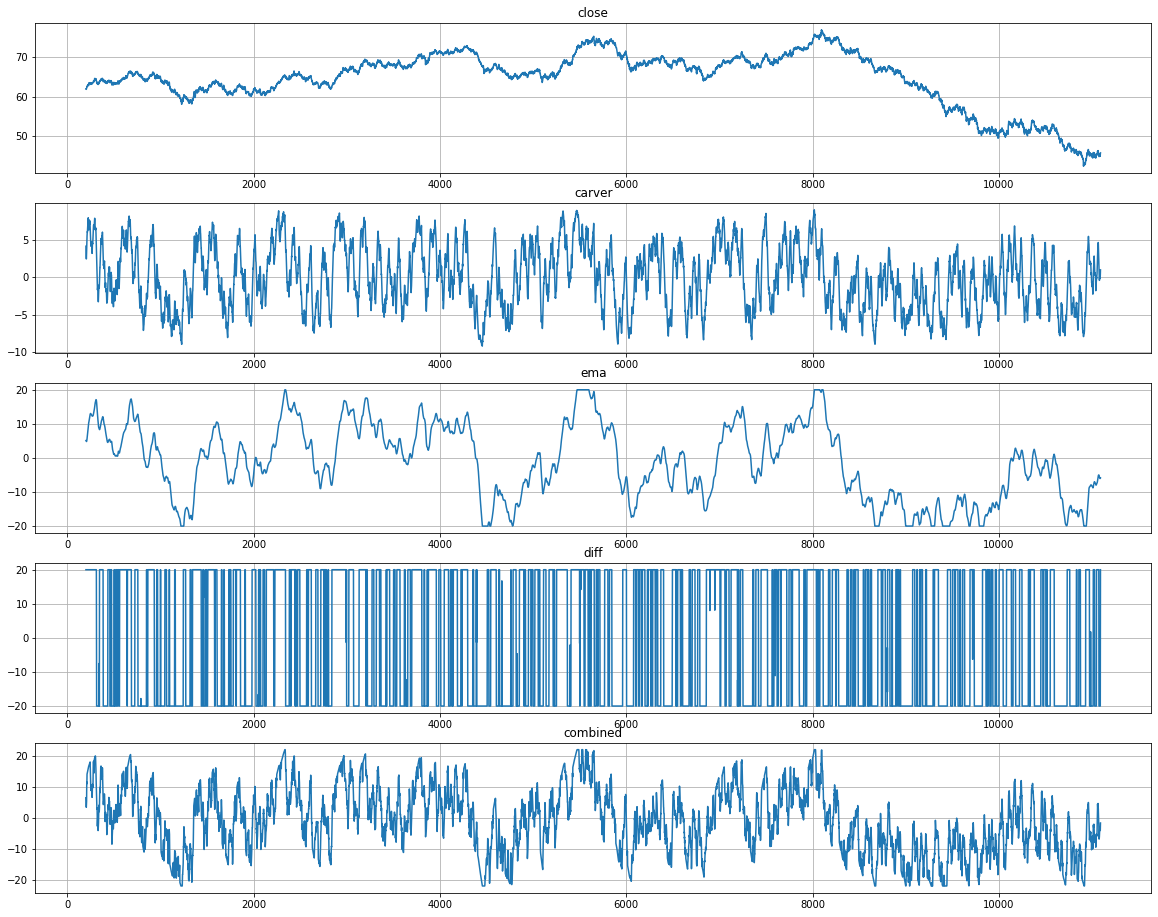

In [27]:
plot(scaled[['close', 'carver', 'ema', 'diff', 'combined']])

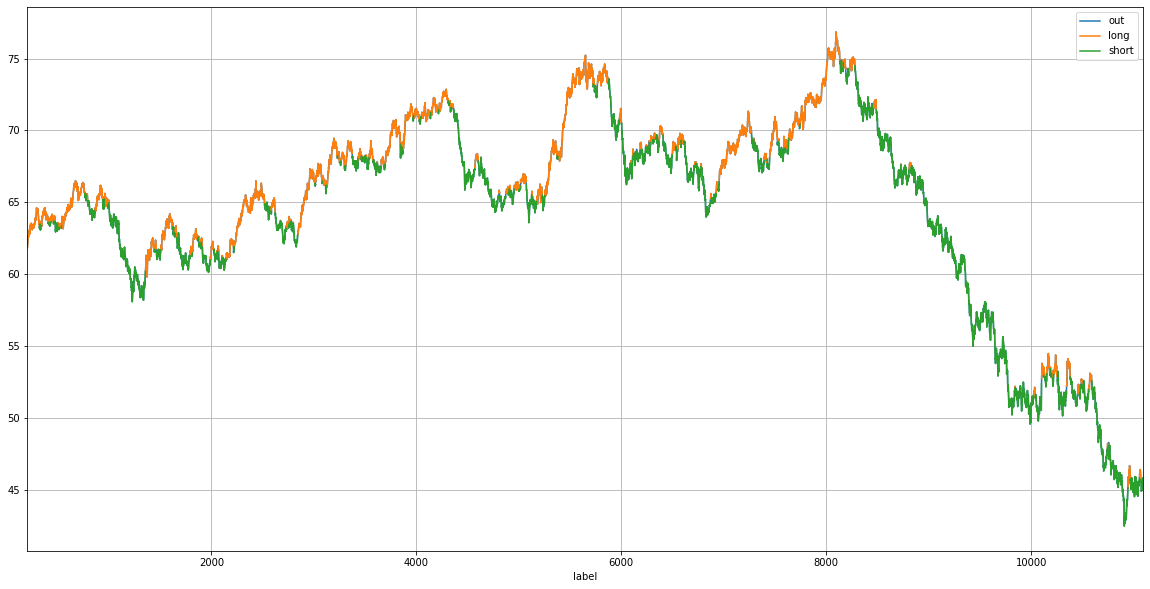

In [28]:
scaled_reindexed = scaled.set_index('date')
chart_price(scaled.close, scaled['combined'], 0);

In [29]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 1, 2, 3, 4, 5, 6, 7, 10, ]: #12, 15, 20]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [30]:
stats

,0,1,2,3,4,5,6,7,10
Annual return,0.45518,0.447762,0.339102,0.302587,0.331357,0.267322,0.345423,0.465754,0.347793
Cumulative returns,0.463871,0.45629,0.345323,0.308065,0.337419,0.272097,0.351774,0.474677,0.354194
Annual volatility,0.258874,0.246377,0.247929,0.234061,0.221824,0.227747,0.204537,0.17819,0.155341
Sharpe ratio,1.57834,1.62465,1.30054,1.24537,1.40017,1.15267,1.55213,2.23522,1.99895
Calmar ratio,4.33282,4.69646,2.9883,3.03587,3.92937,1.96732,3.52779,5.88441,5.30491
Stability,0.691159,0.783174,0.59106,0.62055,0.675346,0.56506,0.83169,0.914706,0.926701
Max drawdown,-0.105054,-0.0953403,-0.113476,-0.0996706,-0.0843284,-0.135881,-0.0979148,-0.0791506,-0.0655605
Omega ratio,1.30041,1.31429,1.24257,1.23247,1.26592,1.22004,1.31272,1.49587,1.52252
Sortino ratio,2.59709,2.8194,2.35859,2.26219,2.67062,2.22031,3.07627,4.71638,4.3262
Skew,0.430361,0.674753,0.991686,0.979525,1.12653,1.29436,1.30379,1.35733,1.70795


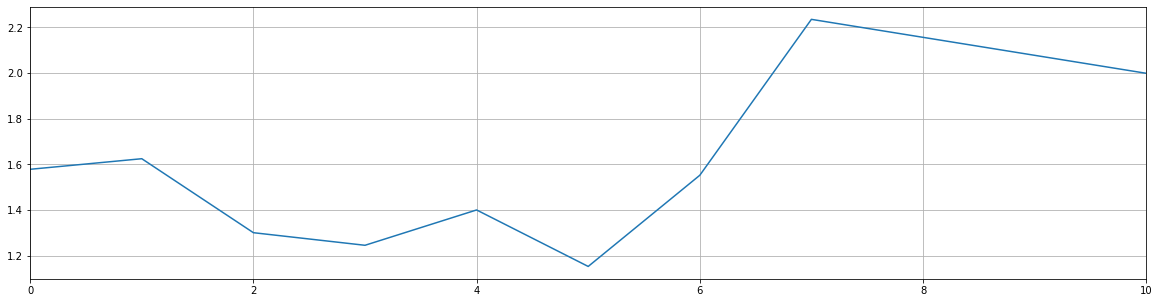

In [31]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

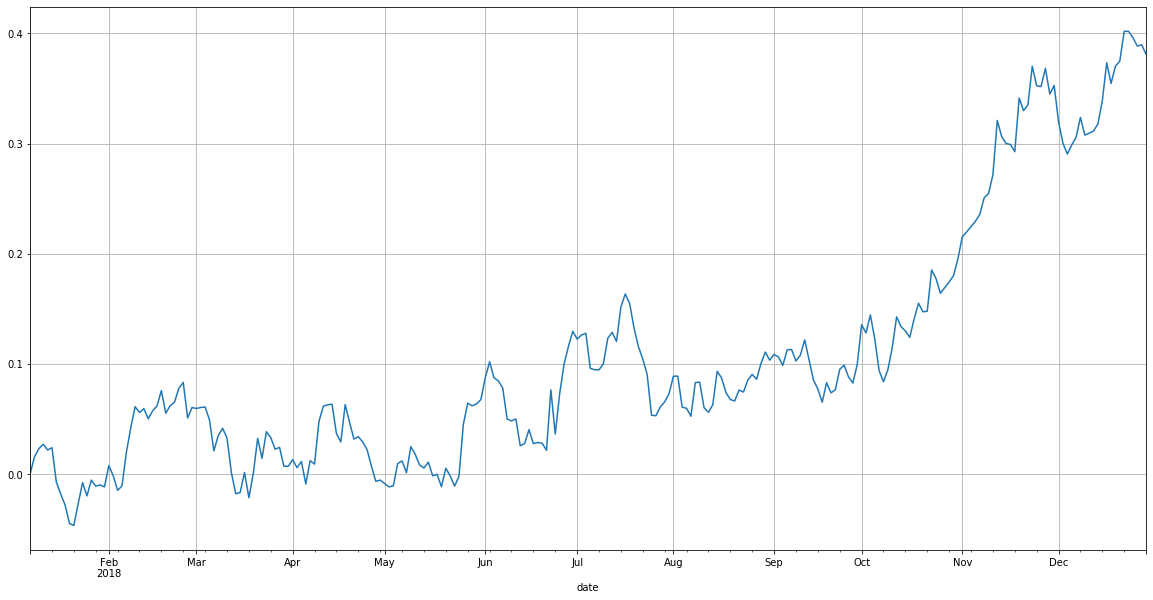

In [32]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [33]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 5, 10, 15]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf(b, multiplier, bankroll, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [34]:
stats

,0,5,10,15
Annual return,0.0377363,0.022138,0.028816,0.0121395
Cumulative returns,0.0383467,0.0224933,0.02928,0.0123333
Annual volatility,0.0239399,0.0200434,0.015225,0.0105914
Sharpe ratio,1.55931,1.10248,1.8736,1.14456
Calmar ratio,3.74416,1.86281,3.92378,3.06365
Stability,0.668158,0.56184,0.923305,0.755317
Max drawdown,-0.0100787,-0.0118842,-0.00734393,-0.00396242
Omega ratio,1.29962,1.21256,1.49069,1.37434
Sortino ratio,2.57227,2.10462,3.99174,2.26976
Skew,0.487331,1.34031,1.78753,2.15369
